## **01 – Exploratory Data Analysis (EDA)**

**Source**

This notebook starts from the **raw LendingClub accepted loans file downloaded using Kaggle's API**:

- `data/raw/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv`

**Goals**
* Inspect the raw schema and key fields
* Define a clean **binary default target**
* Identify obvious **leakage columns** that must be excluded
* Explore distributions, missingness, and temporal patterns
* Produce a short list of **candidate features** for feature engineering and modeling

**To-Do Checklist**  

1. Data Loading & Inspecting Structure
- [x] Load raw dataset (no transformations)  
- [x] Inspect shape (rows, columns)  
- [x] Display full schema and data types  
- [x] Review sample rows (head/tail)  
- [x] Confirm expected columns exist  

2. Target Definition and Validation
- [x] Encode `loan_status` into a binary target (document mapping)  
- [x] Validate target encoding (counts by original category)  
- [x] Examine target imbalance (percentage charged-off vs. not)  

3. Data Quality & Completeness
- [x] Compute non-null counts per column  
- [x] Calculate missing percentages  
- [x] Visualize missingness patterns (heatmap/matrix)  
- [x] Identify impossible or invalid values (e.g., negative income)  
- [x] Check for duplicated rows (if applicable)  

4. Leakage Identification
- [x] Identify columns containing post-origination information  
- [x] Identify columns derived from future performance  
- [x] Document columns to exclude later  

5. Feature Type Categorization
- [x] Categorize columns into numeric / categorical / datetime / ID fields  
- [x] Note any fields with extremely low variance  
- [x] Flag any columns that are constant or mostly placeholder values  

6. Univariate Distributions

    6.1 Numeric Features
    - [x] Summary statistics (mean, median, percentiles)  
    - [x] Distribution plots (histograms/boxplots)  
    - [x] Identify presence of extreme values *(plot only — no removal)*  

    6.2 Categorical Features
    - [x] Category frequency counts  
    - [x] Visualize distributions of key categories (grade, subgrade, purpose)  

7. Target Slicing / Bad-Rate Exploration
- [x] Compute target rate (PD) by categorical feature (grade, subgrade, purpose)  
- [x] Compute target rate by numeric bins (e.g., DTI buckets, income buckets)  
- [x] Highlight categories associated with higher/lower risk  

8. Temporal Structure
- [x] Convert issue/origination dates to datetime  
- [x] Plot loan volume over time  
- [x] Plot target rate (PD) by origination year/quarter  
- [x] Identify underwriting or portfolio drift patterns  

9. Correlations & Associations
- [x] Numeric correlation matrix (Pearson/Spearman)  
- [x] Identify highly correlated variable pairs  
- [x] Categorical association metrics (e.g., Cramér’s V)  
*(No encoding, no dimensionality reduction — descriptive only.)*

10. Feature Family Grouping (Pre-Selection)
- [x] Provide a defensible list of variables grouped by usage at origination

11. Transition: EDA -> Feature Engineering
- [x] Summarize the handoff between notebooks to retain boundaries
- [ ] Create artifacts (summary, schema, and cleaned parquet) that are used moving forward


# **Source**

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("ggplot")

RAW_ACCEPTED_DIR = Path("../data/raw/accepted_2007_to_2018q4.csv")

ACCEPTED_PATH = RAW_ACCEPTED_DIR / "accepted_2007_to_2018Q4.csv"

ACCEPTED_PATH

PosixPath('../data/raw/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv')

# 1. Data Loading & Inspecting Structure

In [2]:
# Load data via two-pass uniform sampling across the entire file to ensure full temporal coverage
# Pass 1 counts rows; Pass 2 samples each row with fixed probability

from typing import List

TARGET_SAMPLE_SIZE: int = 100_000
CHUNK_SIZE: int = 400_000

# Pass 1: count total rows (excluding header)
total_rows: int = 0
with open(ACCEPTED_PATH, "r", encoding="utf-8") as f:
    total_rows = sum(1 for _ in f) - 1
print(f"Total rows (excluding header): {total_rows:,}\n")

keep_prob: float = min(1.0, TARGET_SAMPLE_SIZE / max(total_rows, 1))
print(f"Sampling probability per row: {keep_prob:.6f}")


# Pass 2: sample rows uniformly across all chunks
print("\nSampling rows in chunks:")
samples: List[pd.DataFrame] = []
rows_seen: int = 0
for i, chunk in enumerate(pd.read_csv(ACCEPTED_PATH, chunksize=CHUNK_SIZE, low_memory=False)):
    rows_seen += len(chunk)
    chunk_sample: pd.DataFrame = chunk.sample(frac=keep_prob, random_state=42 + i)
    samples.append(chunk_sample)
    print(
        f"  Chunk {i + 1}: {len(chunk):,} rows, kept {len(chunk_sample):,} (rows seen {rows_seen:,})"
    )

# Combine sampled rows
df_raw: pd.DataFrame = pd.concat(samples, ignore_index=True)

# If we have slightly more than target, downsample to exact target
if len(df_raw) > TARGET_SAMPLE_SIZE:
    sample_n: pd.DataFrame = df_raw.sample(n=TARGET_SAMPLE_SIZE, random_state=42)
else:
    sample_n = df_raw

print(f"\nFinal sample: {len(sample_n):,} rows from {total_rows:,} total rows\n")

# Quick date coverage check to verify we captured early years
_date_candidates = [c for c in sample_n.columns if c.lower() in ("issue_d", "origination_date")]
if _date_candidates:
    _date_col = _date_candidates[0]
    sample_n[_date_col] = pd.to_datetime(sample_n[_date_col], format="%b-%Y", errors="coerce")
    date_series = pd.to_datetime(sample_n[_date_col], errors="coerce").dropna()
    if not date_series.empty:
        print("Sample date coverage:", date_series.min(), "to", date_series.max(), "\n")
        year_counts = date_series.dt.year.value_counts().sort_index()
        print(year_counts.head(15))
    else:
        print("No valid dates after parsing; check date format or source data.")

Total rows (excluding header): 2,260,701

Sampling probability per row: 0.044234

Sampling rows in chunks:
  Chunk 1: 400,000 rows, kept 17,694 (rows seen 400,000)
  Chunk 2: 400,000 rows, kept 17,694 (rows seen 800,000)
  Chunk 3: 400,000 rows, kept 17,694 (rows seen 1,200,000)
  Chunk 4: 400,000 rows, kept 17,694 (rows seen 1,600,000)
  Chunk 5: 400,000 rows, kept 17,694 (rows seen 2,000,000)
  Chunk 6: 260,701 rows, kept 11,532 (rows seen 2,260,701)

Final sample: 100,000 rows from 2,260,701 total rows

Sample date coverage: 2007-06-01 00:00:00 to 2018-12-01 00:00:00 

issue_d
2007       23
2008      104
2009      243
2010      559
2011      922
2012     2379
2013     5941
2014    10463
2015    18612
2016    19108
2017    19731
2018    21915
Name: count, dtype: int64


In [3]:
# Inspect shape (rows, columns), display full schema and data types, review sample rows (head/tail), and confirm expected columns exist

# Print the shape of the sampled DataFrame
print("The sample shape has:", sample_n.shape[0], "rows and", sample_n.shape[1], "columns.\n")

# Display first few rows of the sampled DataFrame
print("First few rows of the sample:")
print(sample_n.head(), "\n")

# Display last few rows of the sampled DataFrame
print("Last few rows of the sample:")
print(sample_n.tail(), "\n")

# Display summary information about the sampled DataFrame
print("Sample DataFrame info:")
sample_n.info()

# Display basic statistics of the sampled DataFrame
print("\nSample DataFrame statistics:")
print(sample_n.describe(include="all"))

# Display schema of the sampled DataFrame with data types as a table
print("\nSample DataFrame schema:")
df = pd.DataFrame(
    {"Column": sample_n.columns, "Data Type": [sample_n[col].dtype for col in sample_n.columns]}
)

print(df.to_string(index=False))

The sample shape has: 100000 rows and 151 columns.

First few rows of the sample:
              id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
62004  141584200        NaN    10400.0      10400.0          10400.0   
58589   17543141        NaN    16000.0      16000.0          16000.0   
1956    50789430        NaN     7000.0       7000.0           7000.0   
11529   58792426        NaN    24000.0      24000.0          24000.0   
39495   75669039        NaN    10000.0      10000.0           9950.0   

             term  int_rate  installment grade sub_grade  ...  \
62004   60 months      6.67       204.32     A        A2  ...   
58589   60 months     13.98       372.13     C        C3  ...   
1956    36 months      9.99       225.84     B        B3  ...   
11529   60 months      9.17       500.19     B        B2  ...   
39495   36 months     13.67       340.18     C        C3  ...   

      hardship_payoff_balance_amount hardship_last_payment_amount  \
62004                    

# 2. Target Definition and Validation

In [4]:
# Encode loan_status column into a binary target variable
# Inspect unique values and their counts for the 'loan_status' column
print("\nValue counts for 'loan_status' column:")
sample_n["loan_status"].value_counts(dropna=False).head(20)
target_raw_header = "loan_status"


Value counts for 'loan_status' column:


In [5]:
# Validate target encoding
# establish default vs. good loan statuses
default_statuses = [
    "Charged Off",
    "Default",
    "Does not meet the credit policy. Status:Charged Off",
    "Late (31-120 days)",
    # optional / conservative:
    "Late (16-30 days)",
]

good_statuses = [
    "Fully Paid",
    "Current",
    "Does not meet the credit policy. Status:Fully Paid",
]

# encode default as binary variable
all_statuses = default_statuses + good_statuses
df = sample_n[sample_n["loan_status"].isin(all_statuses)].copy()
df["default"] = df["loan_status"].isin(default_statuses).astype(int)

df["default"].value_counts(normalize=True).rename("fraction").to_frame()

# add all_status counts and fractions
all_status_counts = df["loan_status"].value_counts()
all_status_fractions = df["loan_status"].value_counts(normalize=True).rename("fraction").to_frame()
all_status_summary = all_status_counts.to_frame(name="count").join(all_status_fractions)

# group by default status as well
all_status_summary["default"] = all_status_summary.index.isin(default_statuses).astype(int)

# aggregate count and fraction by default status
default_grouped = all_status_summary.groupby("default").agg({"count": "sum", "fraction": "sum"})

# calculate total count and fraction
total_count = all_status_summary["count"].sum()
total_fraction = all_status_summary["fraction"].sum()

# append total row to the summary
total_row = pd.DataFrame(
    {"count": [total_count], "fraction": [total_fraction], "default": [None]}, index=["total"]
)
all_status_summary = pd.concat([all_status_summary, total_row])

# sort by default column for better readability
all_status_summary = all_status_summary.sort_values(by="default", ascending=False)

print("\nLoan status summary with counts and fractions:")
all_status_summary


Loan status summary with counts and fractions:


,count,fraction,default
Charged Off,11886,0.119323,1
Late (31-120 days),883,0.008864,1
Late (16-30 days),185,0.001857,1
Does not meet the credit policy. Status:Charged Off,38,0.000381,1
Default,2,0.000020,1
Fully Paid,47760,0.479460,0
Current,38774,0.389250,0
Does not meet the credit policy. Status:Fully Paid,84,0.000843,0
total,99612,1.000000,None


Type of first patch: <class 'matplotlib.patches.Rectangle'>


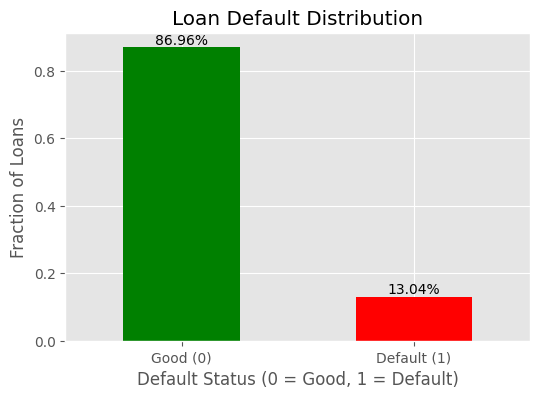

In [6]:
# plot target distribution and examine charge-off rate visually
# add percentages to bar plot
ax = (
    df["default"]
    .value_counts(normalize=True)
    .sort_index()
    .plot(kind="bar", color=["green", "red"], figsize=(6, 4))
)
ax.set_title("Loan Default Distribution")
ax.set_xlabel("Default Status (0 = Good, 1 = Default)")
ax.set_ylabel("Fraction of Loans")
print(f"Type of first patch: {type(ax.patches[0])}")
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2%}", (p.get_x() + p.get_width() / 2, height), ha="center", va="bottom")
plt.xticks(ticks=[0, 1], labels=["Good (0)", "Default (1)"], rotation=0)
plt.show()

# 3. Data Quality & Completeness

In [7]:
# compute non-null counts for each column
non_null_counts = df.notnull().sum().rename("non_null_count").to_frame()
non_null_counts

,non_null_count
id,99612
member_id,0
loan_amnt,99612
funded_amnt,99612
funded_amnt_inv,99612
...,...
settlement_date,1544
settlement_amount,1544
settlement_percentage,1544
settlement_term,1544


In [8]:
# calculate missing value fractions
missing_fractions = (
    (1 - (non_null_counts["non_null_count"] / len(df))).rename("missing_fraction").to_frame()
)
missing_fractions

,missing_fraction
id,0.0000
member_id,1.0000
loan_amnt,0.0000
funded_amnt,0.0000
funded_amnt_inv,0.0000
...,...
settlement_date,0.9845
settlement_amount,0.9845
settlement_percentage,0.9845
settlement_term,0.9845


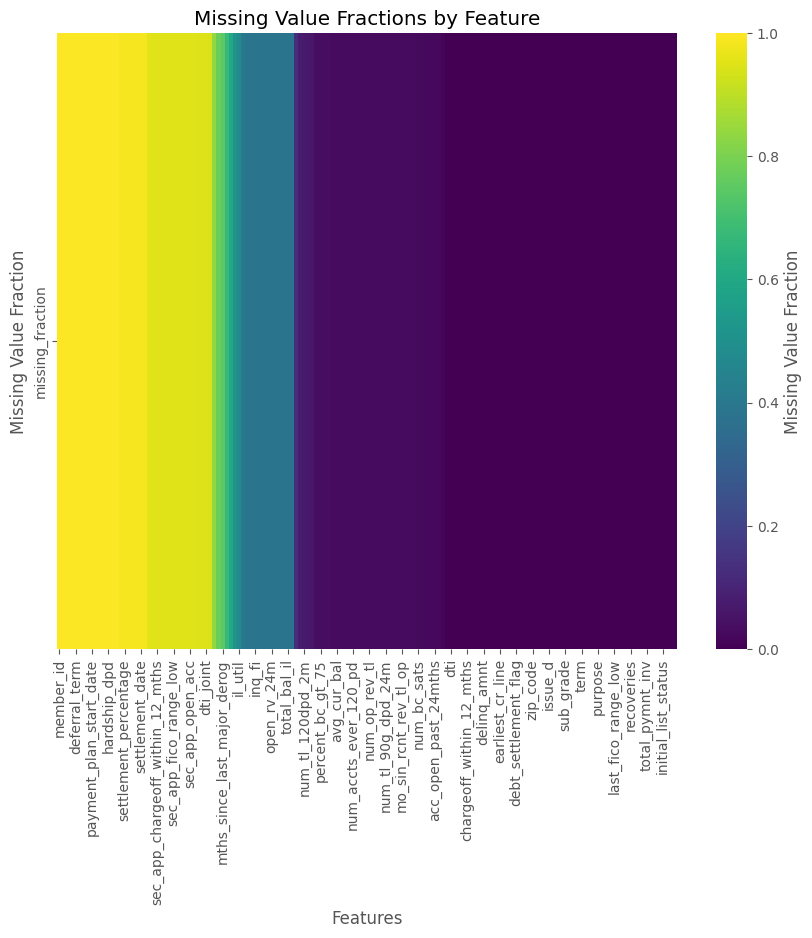

In [9]:
# visualize missing value fractions with a heatmap
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    missing_fractions.sort_values(by="missing_fraction", ascending=False).T,
    cmap="viridis",
    cbar_kws={"label": "Missing Value Fraction"},
)
plt.title("Missing Value Fractions by Feature")
plt.xlabel("Features")
plt.ylabel("Missing Value Fraction")
plt.show()

In [10]:
# identify impossible or invalid values in numeric columns
numeric_cols = df.select_dtypes(include=["number"]).columns
invalid_values = {}
for col in numeric_cols:
    invalid_mask = df[col] < 0
    invalid_count = invalid_mask.sum()
    if invalid_count > 0:
        invalid_values[col] = invalid_count

invalid_values

{}

In [11]:
# check for duplicate rows in the DataFrame
duplicate_mask = df.duplicated()
duplicate_count = duplicate_mask.sum()
duplicate_count

np.int64(0)

# 4. Leakage Identification


In [12]:
# identify columns containing post-origination information

leakage_keywords = [
    "pymnt",
    "payment",
    "last_pymnt",
    "last_credit_pull",
    "recoveries",
    "collection",
    "total_rec",
    "out_prncp",
    "funded_amnt_inv",
    "settlement",
    "policy_code",
    "hardship",
    "status",
    "id",
    "title",
    "url",
    "desc",  # add back in if needed for NLP tasks
    "orig_projected_additional_accrued_interest",
    "last_fico",
]

leak_cols = sorted({c for c in df.columns for kw in leakage_keywords if kw.lower() in c.lower()})

len(leak_cols), leak_cols[:40]

(51,
 ['collection_recovery_fee',
  'collections_12_mths_ex_med',
  'debt_settlement_flag',
  'debt_settlement_flag_date',
  'desc',
  'emp_title',
  'funded_amnt_inv',
  'hardship_amount',
  'hardship_dpd',
  'hardship_end_date',
  'hardship_flag',
  'hardship_last_payment_amount',
  'hardship_length',
  'hardship_loan_status',
  'hardship_payoff_balance_amount',
  'hardship_reason',
  'hardship_start_date',
  'hardship_status',
  'hardship_type',
  'id',
  'initial_list_status',
  'last_credit_pull_d',
  'last_fico_range_high',
  'last_fico_range_low',
  'last_pymnt_amnt',
  'last_pymnt_d',
  'loan_status',
  'member_id',
  'next_pymnt_d',
  'orig_projected_additional_accrued_interest',
  'out_prncp',
  'out_prncp_inv',
  'payment_plan_start_date',
  'policy_code',
  'pymnt_plan',
  'recoveries',
  'sec_app_collections_12_mths_ex_med',
  'settlement_amount',
  'settlement_date',
  'settlement_percentage'])

In [13]:
# identify columns derived from future performance metrics
future_keywords = [
    "mths_since",
    "num_accts",
    "inq_last",
    "earliest_cr_line",
    "revol_util",
    "acc_now_delinq",
]

future_cols = sorted({c for c in df.columns for kw in future_keywords if kw.lower() in c.lower()})
len(future_cols), future_cols[:40]

(18,
 ['acc_now_delinq',
  'earliest_cr_line',
  'inq_last_12m',
  'inq_last_6mths',
  'mths_since_last_delinq',
  'mths_since_last_major_derog',
  'mths_since_last_record',
  'mths_since_rcnt_il',
  'mths_since_recent_bc',
  'mths_since_recent_bc_dlq',
  'mths_since_recent_inq',
  'mths_since_recent_revol_delinq',
  'num_accts_ever_120_pd',
  'revol_util',
  'sec_app_earliest_cr_line',
  'sec_app_inq_last_6mths',
  'sec_app_mths_since_last_major_derog',
  'sec_app_revol_util'])

In [14]:
# document columns to drop in the future due to leakage or irrelevance
cols_to_drop = sorted(set(leak_cols + future_cols))
len(cols_to_drop), cols_to_drop[:40]

(69,
 ['acc_now_delinq',
  'collection_recovery_fee',
  'collections_12_mths_ex_med',
  'debt_settlement_flag',
  'debt_settlement_flag_date',
  'desc',
  'earliest_cr_line',
  'emp_title',
  'funded_amnt_inv',
  'hardship_amount',
  'hardship_dpd',
  'hardship_end_date',
  'hardship_flag',
  'hardship_last_payment_amount',
  'hardship_length',
  'hardship_loan_status',
  'hardship_payoff_balance_amount',
  'hardship_reason',
  'hardship_start_date',
  'hardship_status',
  'hardship_type',
  'id',
  'initial_list_status',
  'inq_last_12m',
  'inq_last_6mths',
  'last_credit_pull_d',
  'last_fico_range_high',
  'last_fico_range_low',
  'last_pymnt_amnt',
  'last_pymnt_d',
  'loan_status',
  'member_id',
  'mths_since_last_delinq',
  'mths_since_last_major_derog',
  'mths_since_last_record',
  'mths_since_rcnt_il',
  'mths_since_recent_bc',
  'mths_since_recent_bc_dlq',
  'mths_since_recent_inq',
  'mths_since_recent_revol_delinq'])

# 5. Feature Type Categorization

In [15]:
# categorize columns by data type for further analysis
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = df.select_dtypes(include=["number"]).columns.tolist()
datetime_cols = df.select_dtypes(include=["datetime", "datetimetz"]).columns.tolist()
id_cols = [col for col in df.columns if "id" in col.lower() or col.endswith("_num")]

numerical_cols.remove("default")  # exclude target variable from numerical features

len(categorical_cols), len(numerical_cols), len(datetime_cols), len(id_cols)

(37, 113, 1, 2)

In [16]:
# create list of any columns with extremely low variance (single unique value)
low_variance_cols = [col for col in df.columns if df[col].nunique() <= 1]
len(low_variance_cols), low_variance_cols

(5,
 ['member_id',
  'policy_code',
  'hardship_type',
  'deferral_term',
  'hardship_length'])

In [17]:
# flag columns that are constant or mostly placeholder values
constant_cols = []
for col in df.columns:
    if col.startswith("tax_liens"):
        continue
    top_value = df[col].mode(dropna=False).iloc[0]
    top_count = (df[col] == top_value).sum()
    if top_count / len(df) >= 0.95:
        constant_cols.append(col)
constant_cols

['pymnt_plan',
 'total_rec_late_fee',
 'collections_12_mths_ex_med',
 'policy_code',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'num_tl_30dpd',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag']

# 6. Univariate Distributions

_6.1 Numeric Features_

In [18]:
# compute summary statistics for numerical columns
numerical_summary = df[numerical_cols].describe().T
numerical_summary

,count,mean,std,min,25%,50%,75%,max
member_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,99612.0,15061.745071,9184.407671,950.00,8000.0000,12950.000,20000.00,40000.00
funded_amnt,99612.0,15056.650554,9182.867988,950.00,8000.0000,12925.000,20000.00,40000.00
funded_amnt_inv,99612.0,15038.319534,9186.381449,0.00,8000.0000,12825.000,20000.00,40000.00
int_rate,99612.0,13.064476,4.822809,5.31,9.4900,12.620,15.99,30.99
...,...,...,...,...,...,...,...,...
hardship_payoff_balance_amount,477.0,12209.717212,8046.379461,750.93,5503.7800,10764.080,17515.30,40306.41
hardship_last_payment_amount,477.0,196.500398,197.640646,0.01,42.9200,134.620,291.78,1129.98
settlement_amount,1544.0,4970.486898,3616.412383,173.00,2214.2425,4195.405,6814.62,23555.34
settlement_percentage,1544.0,47.960777,7.402990,0.20,45.0000,45.010,50.00,166.67


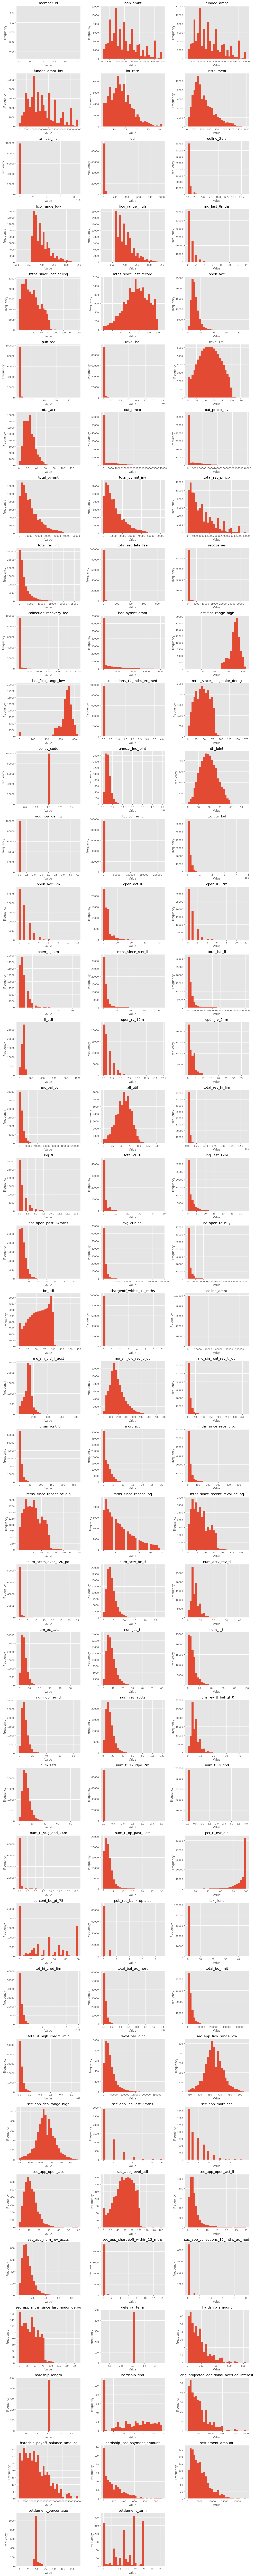

In [19]:
# plot histograms for numerical columns to visualize distributions
import math

num_plots = len(numerical_cols)
cols_per_row = 3
num_rows = math.ceil(num_plots / cols_per_row)
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, num_rows * 4))
for i, col in enumerate(numerical_cols):
    row = i // cols_per_row
    col_idx = i % cols_per_row
    ax = axes[row, col_idx] if num_rows > 1 else axes[col_idx]
    df[col].hist(bins=30, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
# Remove any empty subplots
for j in range(i + 1, num_rows * cols_per_row):
    row = j // cols_per_row
    col_idx = j % cols_per_row
    ax = axes[row, col_idx] if num_rows > 1 else axes[col_idx]
    fig.delaxes(ax)
plt.tight_layout()
plt.show()

In [20]:
# identify extreme outliers in numerical columns using IQR method
outlier_info = {}
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_count = outlier_mask.sum()
    if outlier_count > 0:
        outlier_info[col] = {
            "outlier_count": outlier_count,
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
        }
outlier_info

{'loan_amnt': {'outlier_count': np.int64(1518),
  'lower_bound': np.float64(-10000.0),
  'upper_bound': np.float64(38000.0)},
 'funded_amnt': {'outlier_count': np.int64(1518),
  'lower_bound': np.float64(-10000.0),
  'upper_bound': np.float64(38000.0)},
 'funded_amnt_inv': {'outlier_count': np.int64(1518),
  'lower_bound': np.float64(-10000.0),
  'upper_bound': np.float64(38000.0)},
 'int_rate': {'outlier_count': np.int64(1778),
  'lower_bound': np.float64(-0.2599999999999998),
  'upper_bound': np.float64(25.740000000000002)},
 'installment': {'outlier_count': np.int64(2937),
  'lower_bound': np.float64(-262.765),
  'upper_bound': np.float64(1110.315)},
 'annual_inc': {'outlier_count': np.int64(4877),
  'lower_bound': np.float64(-23871.25),
  'upper_bound': np.float64(163122.75)},
 'dti': {'outlier_count': np.int64(968),
  'lower_bound': np.float64(-7.040000000000003),
  'upper_bound': np.float64(43.36)},
 'delinq_2yrs': {'outlier_count': np.int64(18787),
  'lower_bound': np.float64(0.

_6.2 Categorical Features_

In [21]:
# frequency counts for categorical columns
categorical_frequencies = {}
for col in categorical_cols:
    value_counts = df[col].value_counts(dropna=False)
    categorical_frequencies[col] = value_counts
categorical_frequencies

{'id': id
 141584200    1
 20810081     1
 12766151     1
 27701143     1
 134228099    1
             ..
 143641599    1
 33341162     1
 67948283     1
 46725954     1
 102436829    1
 Name: count, Length: 99612, dtype: int64,
 'term': term
 36 months    71129
 60 months    28483
 Name: count, dtype: int64,
 'grade': grade
 B    29227
 C    28678
 A    19305
 D    14208
 E     5836
 F     1810
 G      548
 Name: count, dtype: int64,
 'sub_grade': sub_grade
 C1    6449
 B5    6225
 B4    6191
 C2    5807
 B3    5780
 C3    5678
 C4    5593
 B2    5560
 B1    5471
 C5    5151
 A5    4728
 A4    4368
 A1    3897
 D1    3514
 A3    3307
 D2    3144
 A2    3005
 D3    2837
 D4    2607
 D5    2106
 E1    1438
 E2    1304
 E3    1143
 E4     984
 E5     967
 F1     590
 F2     396
 F3     307
 F4     302
 F5     215
 G1     190
 G2     108
 G3      85
 G5      84
 G4      81
 Name: count, dtype: int64,
 'emp_title': emp_title
 NaN                      7415
 Teacher                  1764
 Ma

,mean,count
grade,,
A,0.036571,19305
B,0.088172,29227
C,0.147395,28678
D,0.206011,14208
E,0.285298,5836
F,0.368508,1810
G,0.410584,548


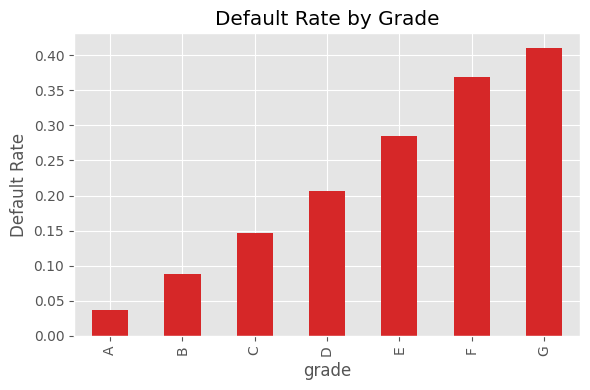

,mean,count
sub_grade,,
F4,0.430464,302
F2,0.386364,396
F3,0.381107,307
F1,0.335593,590
E2,0.322853,1304
F5,0.320930,215
E4,0.305894,984
E1,0.270515,1438
E5,0.262668,967


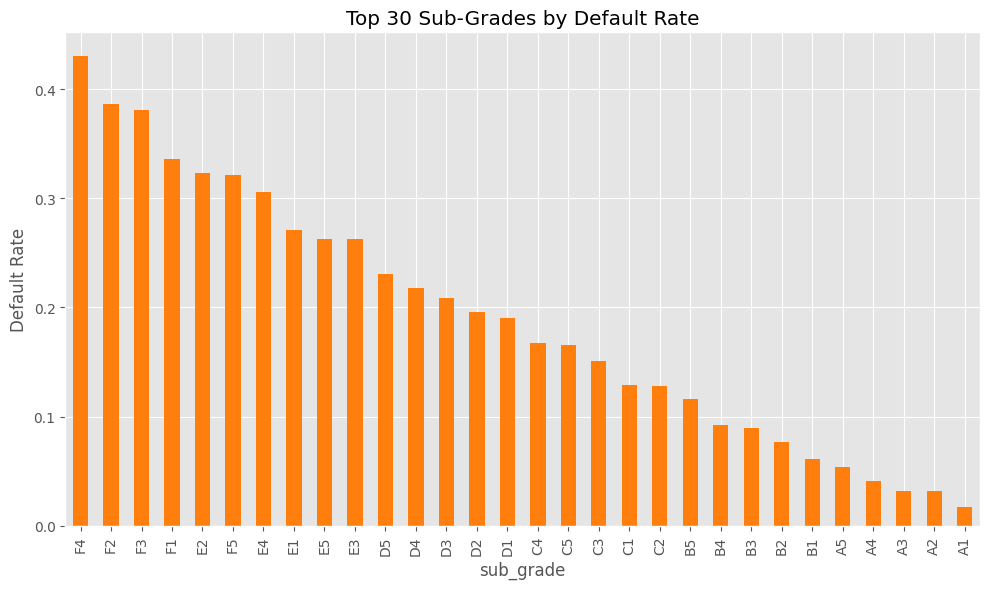

In [22]:
# visualize distribution of target variable across different grades and sub-grades
target_col = "default"

if "grade" in df.columns:
    grade_stats = df.groupby("grade")[target_col].agg(["mean", "count"]).sort_index()
    display(grade_stats)
    fig, ax = plt.subplots(figsize=(6, 4))
    grade_stats["mean"].plot(kind="bar", ax=ax, color="tab:red")
    ax.set_ylabel("Default Rate")
    ax.set_title("Default Rate by Grade")
    plt.tight_layout()
    plt.show()

if "sub_grade" in df.columns:
    sub_stats = df.groupby("sub_grade")[target_col].agg(["mean", "count"])
    sub_stats = sub_stats[sub_stats["count"] > 200]  # filter rare
    sub_stats = sub_stats.sort_values("mean", ascending=False).head(30)
    display(sub_stats.head(20))
    fig, ax = plt.subplots(figsize=(10, 6))
    sub_stats["mean"].plot(kind="bar", ax=ax, color="tab:orange")
    ax.set_ylabel("Default Rate")
    ax.set_title("Top 30 Sub-Grades by Default Rate")
    plt.tight_layout()
    plt.show()

,mean,count
purpose,,
educational,0.333333,12
small_business,0.227732,1089
renewable_energy,0.196721,61
moving,0.166185,692
debt_consolidation,0.141020,55992
wedding,0.140187,107
other,0.136021,6227
house,0.135861,633
medical,0.130616,1202


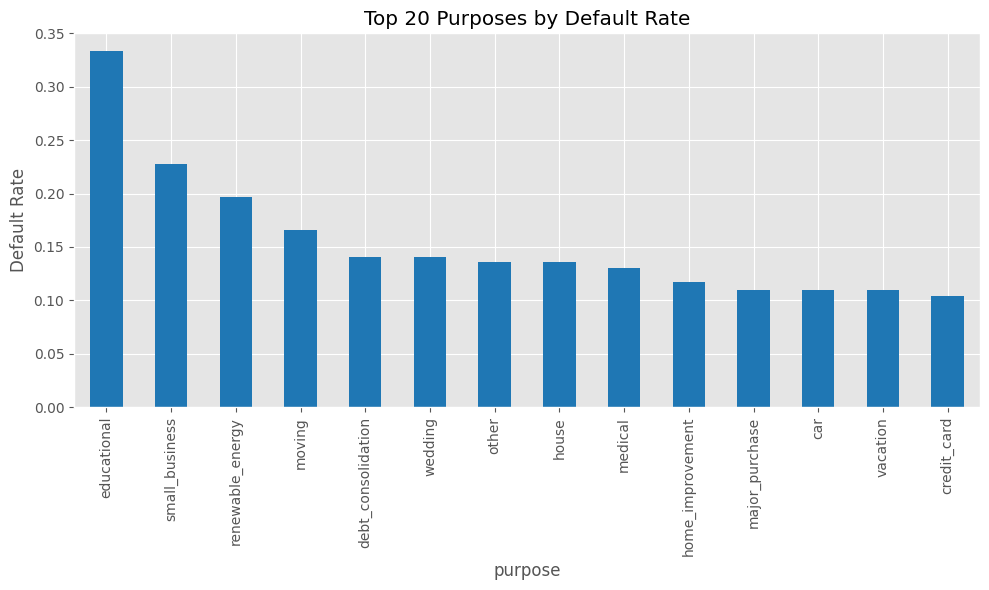

In [23]:
# visualize distribution of target variable across different purposes
if "purpose" in df.columns:
    purpose_stats = (
        df.groupby("purpose")[target_col]
        .agg(["mean", "count"])
        .sort_values("mean", ascending=False)
    )
    display(purpose_stats.head(20))
    fig, ax = plt.subplots(figsize=(10, 6))
    purpose_stats["mean"].head(20).plot(kind="bar", ax=ax, color="tab:blue")
    ax.set_ylabel("Default Rate")
    ax.set_title("Top 20 Purposes by Default Rate")
    plt.tight_layout()
    plt.show()

# 7. Target Slicing / Bad-Rate Exploration 

In [24]:
# compute target rate by categorical feature (grade, sub_grade, purpose)
# map categorical columns to target mean
categorical_target_rates = {}
for col in categorical_cols:
    target_rate_map = df.groupby(col)[target_col].mean()
    categorical_target_rates[col] = target_rate_map

In [25]:
# compute target rate by numerical bins
numerical_target_rates = {}
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for col in numerical_cols:
    binned_col = pd.cut(df[col], bins=bins)
    target_rate_map = df.groupby(binned_col)[target_col].mean()
    numerical_target_rates[col] = target_rate_map

/var/folders/xw/d_8wpw7j3d78hjl58tv4g7m00000gn/T/ipykernel_9295/1323320823.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_rate_map = df.groupby(binned_col)[target_col].mean()


In [26]:
# highlight categories with associated higher/lower default rates
for col, target_rate_map in categorical_target_rates.items():
    high_risk = target_rate_map[target_rate_map > target_rate_map.mean()].index.tolist()
    low_risk = target_rate_map[target_rate_map <= target_rate_map.mean()].index.tolist()
    print(f"Column: {col}")
    print(
        f"  High risk categories (above average default rate): {high_risk[:5]}{'...' if len(high_risk) > 5 else ''}"
    )
    print(
        f"  Low risk categories (below average default rate): {low_risk[:5]}{'...' if len(low_risk) > 5 else ''}\n"
    )

Column: id
  High risk categories (above average default rate): [559073, 11457166, 12616214, 15690415, 16321392]...
  Low risk categories (below average default rate): [65419, 617002, 682965, 1549157, 1586162]...

Column: term
  High risk categories (above average default rate): [' 60 months']
  Low risk categories (below average default rate): [' 36 months']

Column: grade
  High risk categories (above average default rate): ['E', 'F', 'G']
  Low risk categories (below average default rate): ['A', 'B', 'C', 'D']

Column: sub_grade
  High risk categories (above average default rate): ['D5', 'E1', 'E2', 'E3', 'E4']...
  Low risk categories (below average default rate): ['A1', 'A2', 'A3', 'A4', 'A5']...

Column: emp_title
  High risk categories (above average default rate): [' \tOFFICE MANAGER/MEDICAL ASSISTANT', '  I am the owner ', ' Dairy LLC', ' Equipment operator ', ' Financial service manager ']...
  Low risk categories (below average default rate): [' AMBULATORY RN CLINIC SUPERVIS

# 8. Temporal Structure

In [27]:
# convert issue_d or origination_date to datetime and verify date range
date_col_candidates = [c for c in df.columns if c.lower() in ("issue_d", "origination_date")]
date_col_candidates

['issue_d']

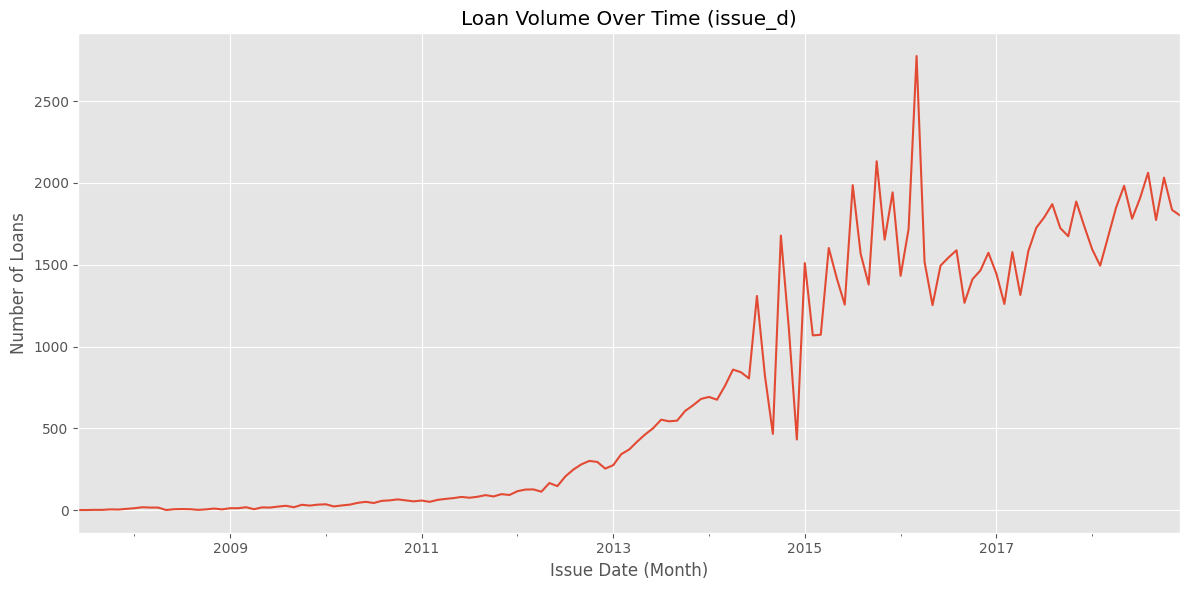

In [28]:
# plot volume over time
if date_col_candidates:
    date_col = date_col_candidates[0]
    df[date_col] = pd.to_datetime(df[date_col], format="%b-%Y", errors="coerce")
    date_series = pd.to_datetime(df[date_col], errors="coerce").dropna()
    if not date_series.empty:
        date_counts = date_series.dt.to_period("M").value_counts().sort_index()
        fig, ax = plt.subplots(figsize=(12, 6))
        date_counts.plot(ax=ax)
        ax.set_title(f"Loan Volume Over Time ({date_col})")
        ax.set_xlabel("Issue Date (Month)")
        ax.set_ylabel("Number of Loans")
        plt.tight_layout()
        plt.show()

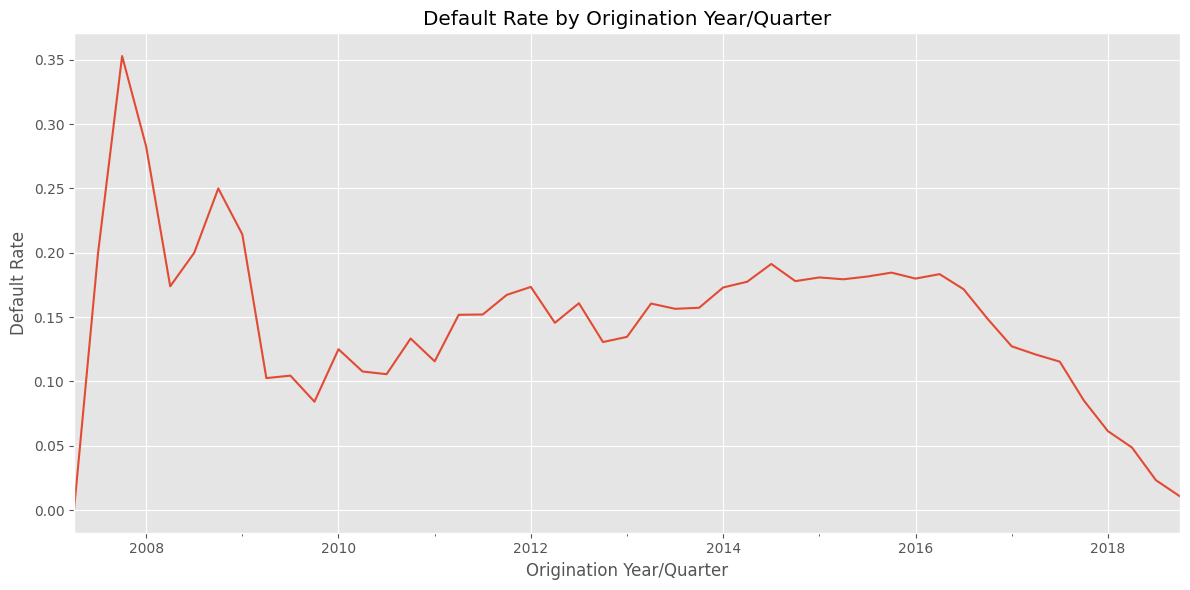

In [29]:
# plot target rate by origination year/quarter
if date_col_candidates:
    date_col = date_col_candidates[0]
    df[date_col] = pd.to_datetime(df[date_col], format="%b-%Y", errors="coerce")
    df["issue_year_quarter"] = df[date_col].dt.to_period("Q")
    target_rate_by_quarter = df.groupby("issue_year_quarter")[target_col].mean()
    fig, ax = plt.subplots(figsize=(12, 6))
    target_rate_by_quarter.plot(ax=ax)
    ax.set_title("Default Rate by Origination Year/Quarter")
    ax.set_xlabel("Origination Year/Quarter")
    ax.set_ylabel("Default Rate")
    plt.tight_layout()
    plt.show()

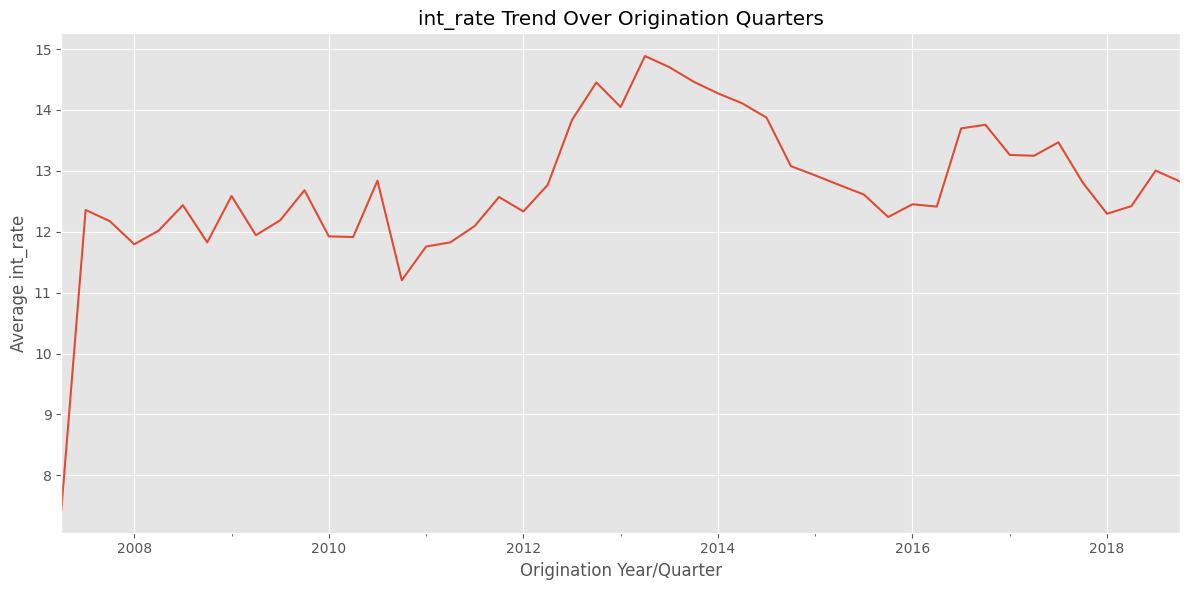

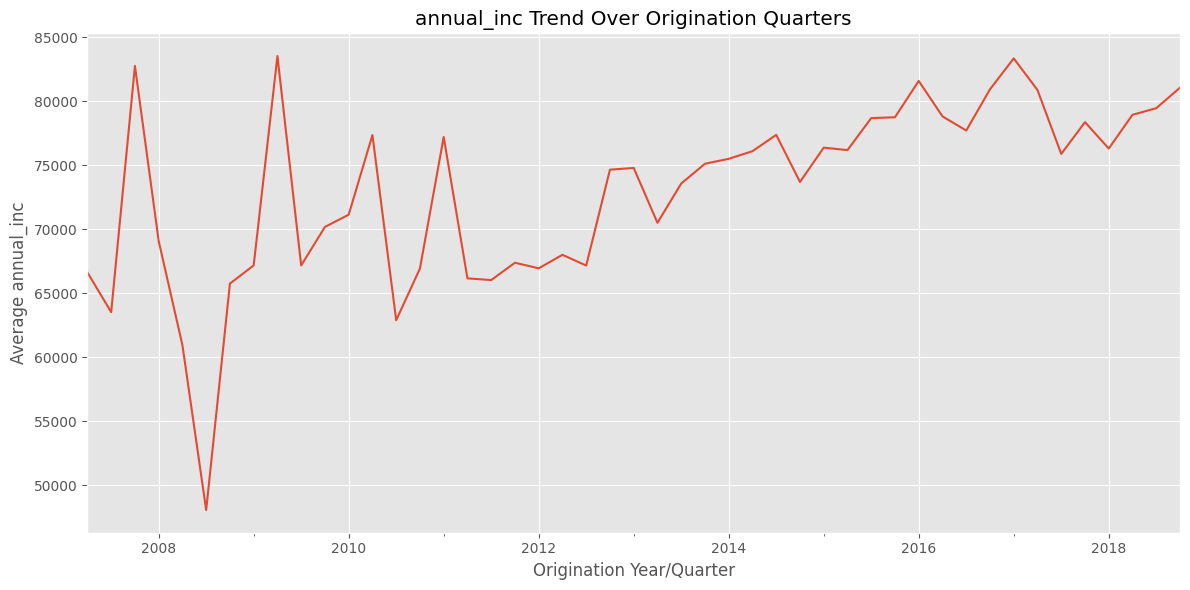

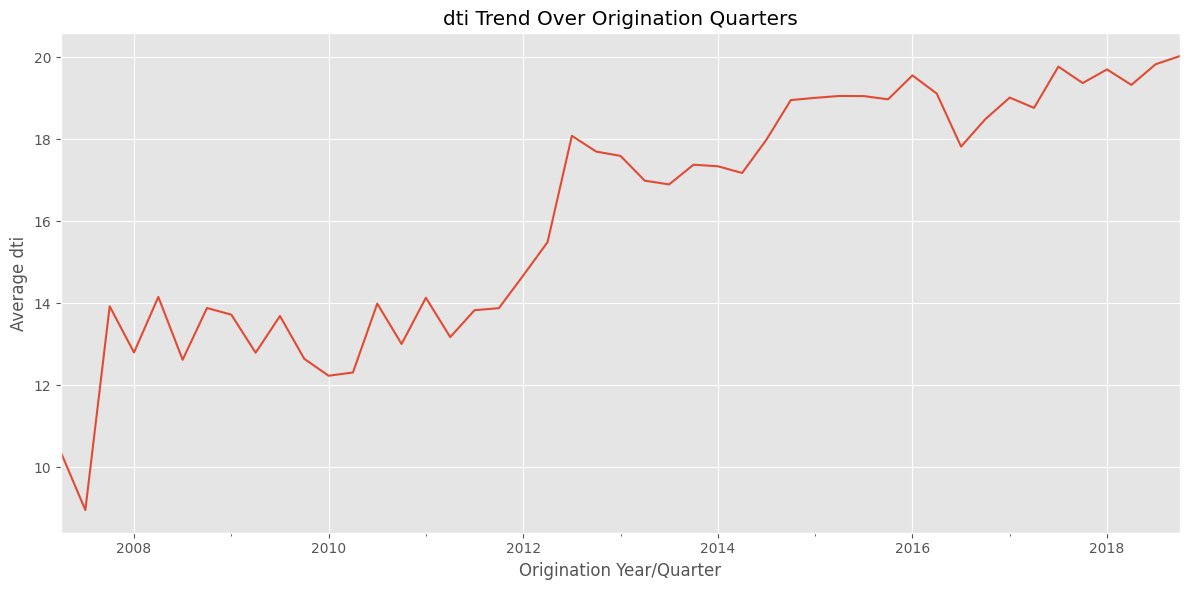

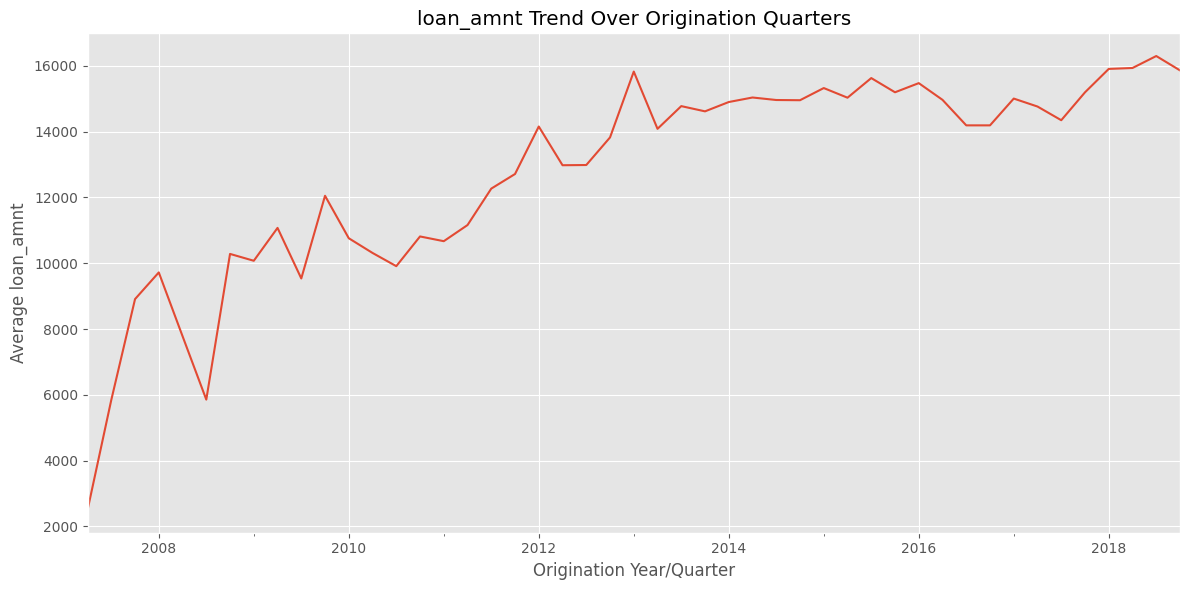

In [30]:
# identify underwriting or portfolio drift patterns over time
# analyze trends in key features over origination quarters
if date_col_candidates:
    date_col = date_col_candidates[0]
    df[date_col] = pd.to_datetime(df[date_col], format="%b-%Y", errors="coerce")
    df["issue_year_quarter"] = df[date_col].dt.to_period("Q")

    key_features = ["int_rate", "annual_inc", "dti", "loan_amnt"]
    for feature in key_features:
        if feature in df.columns:
            feature_trend = df.groupby("issue_year_quarter")[feature].mean()
            fig, ax = plt.subplots(figsize=(12, 6))
            feature_trend.plot(ax=ax)
            ax.set_title(f"{feature} Trend Over Origination Quarters")
            ax.set_xlabel("Origination Year/Quarter")
            ax.set_ylabel(f"Average {feature}")
            plt.tight_layout()
            plt.show()

# 9. Correlations & Associations

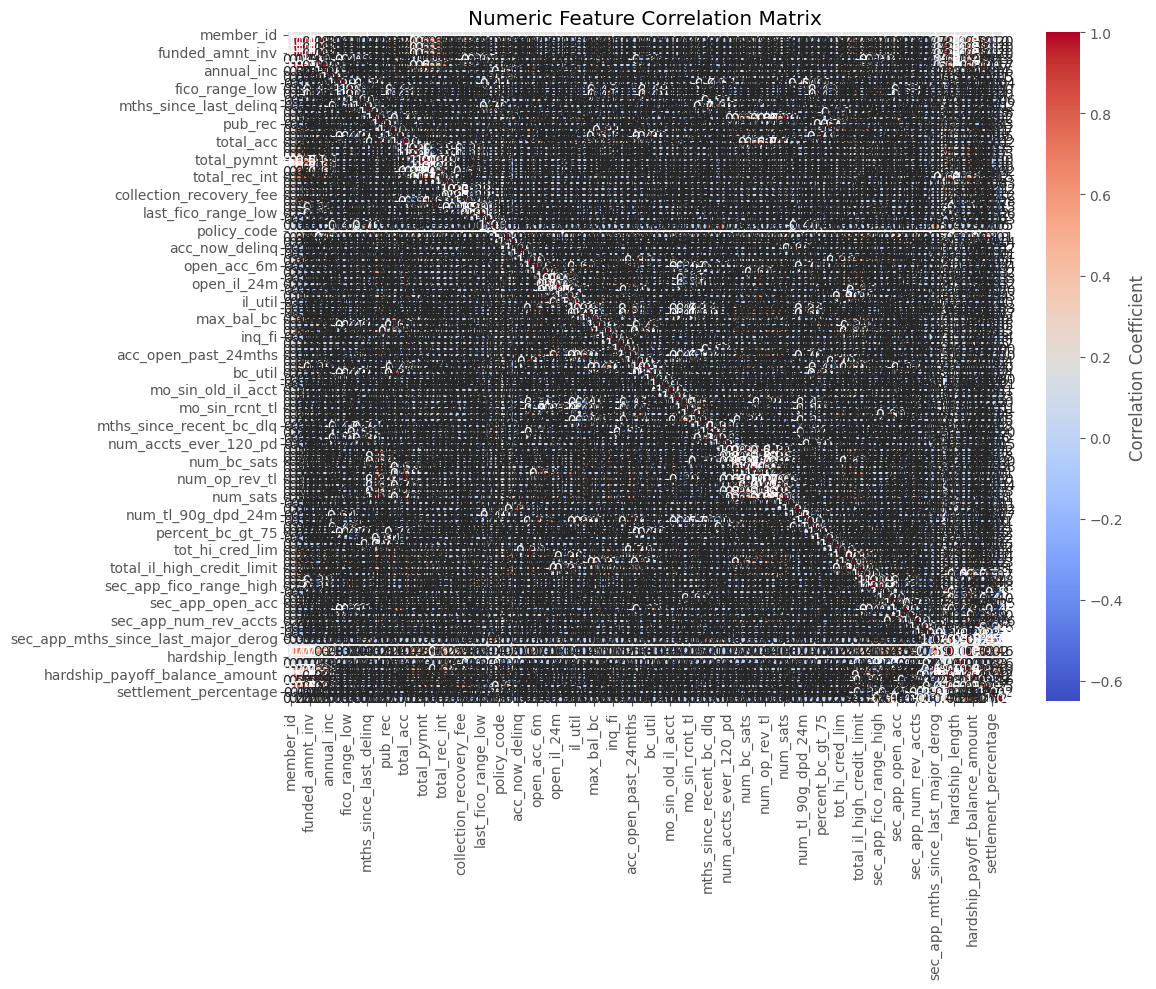

In [31]:
# numeric correlation matrix heatmap
import seaborn as sns

plt.figure(figsize=(12, 10))
corr_matrix = df[numerical_cols].corr()
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={"label": "Correlation Coefficient"},
)
plt.title("Numeric Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [32]:
# identify highly correlated feature pairs for potential multicollinearity
correlation_threshold = 0.8
high_corr_pairs = []
for i in range(len(numerical_cols)):
    for j in range(i + 1, len(numerical_cols)):
        col1 = numerical_cols[i]
        col2 = numerical_cols[j]
        corr_value = corr_matrix.loc[col1, col2]
        # Convert to float and skip NaN values
        try:
            corr_value = float(corr_value)
            if abs(corr_value) >= correlation_threshold:
                high_corr_pairs.append((col1, col2, corr_value))
        except (TypeError, ValueError):
            # Skip if conversion fails (e.g., Timedelta types)
            continue
high_corr_pairs

[('loan_amnt', 'funded_amnt', 0.999777986221871),
 ('loan_amnt', 'funded_amnt_inv', 0.9990773062035377),
 ('loan_amnt', 'installment', 0.9459048532065235),
 ('loan_amnt', 'hardship_payoff_balance_amount', 0.8533009111828004),
 ('funded_amnt', 'funded_amnt_inv', 0.9993318331487472),
 ('funded_amnt', 'installment', 0.9462046060642876),
 ('funded_amnt', 'hardship_payoff_balance_amount', 0.8533009111828004),
 ('funded_amnt_inv', 'installment', 0.9453067013707339),
 ('funded_amnt_inv', 'hardship_payoff_balance_amount', 0.8532585395532962),
 ('fico_range_low', 'fico_range_high', 0.9999999355947783),
 ('mths_since_last_delinq',
  'mths_since_recent_revol_delinq',
  0.8627733962662923),
 ('open_acc', 'num_op_rev_tl', 0.8391138185757011),
 ('open_acc', 'num_sats', 0.9989953248199192),
 ('revol_bal', 'total_rev_hi_lim', 0.8132581940385419),
 ('revol_util', 'bc_util', 0.8679733788088922),
 ('out_prncp', 'out_prncp_inv', 0.999998757278797),
 ('total_pymnt', 'total_pymnt_inv', 0.9993569669724996),


In [33]:
# categorical association metrics - chi-squared tests
from scipy.stats import chi2_contingency

categorical_associations = {}
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df[target_col])
    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        categorical_associations[col] = {"chi2": chi2, "p_value": p, "dof": dof}

categorical_associations

{'id': {'chi2': np.float64(99612.0),
  'p_value': np.float64(0.4985103363343744),
  'dof': 99611},
 'term': {'chi2': np.float64(829.0823763704288),
  'p_value': np.float64(2.5654787043045422e-182),
  'dof': 1},
 'grade': {'chi2': np.float64(5265.379629895802),
  'p_value': np.float64(0.0),
  'dof': 6},
 'sub_grade': {'chi2': np.float64(5542.180267302317),
  'p_value': np.float64(0.0),
  'dof': 34},
 'emp_title': {'chi2': np.float64(42935.760339363835),
  'p_value': np.float64(1.6660507235139732e-09),
  'dof': 41215},
 'emp_length': {'chi2': np.float64(41.0312490798547),
  'p_value': np.float64(1.114133063810393e-05),
  'dof': 10},
 'home_ownership': {'chi2': np.float64(216.42015959352966),
  'p_value': np.float64(8.684222829776462e-45),
  'dof': 5},
 'verification_status': {'chi2': np.float64(847.7598079111403),
  'p_value': np.float64(8.152611034927863e-185),
  'dof': 2},
 'loan_status': {'chi2': np.float64(99612.00000000001),
  'p_value': np.float64(0.0),
  'dof': 7},
 'pymnt_plan': 

# 10. Feature Family Grouping (Pre-Selection)

The following section organizes the EDA-approved feature set into **conceptual feature families** based on data source and semantic meaning.  
This grouping is **descriptive only** and is intended to support downstream feature engineering, documentation, and model interpretability.

No feature selection, transformation, or prioritization is implied.

---

## 10.1. Loan Terms & Pricing (Origination Attributes)
Variables describing the contractual structure of the loan at issuance.

- `loan_amnt`
- `funded_amnt`
- `term`
- `int_rate`
- `installment`
- `grade`
- `sub_grade`

---

## 10.2. Borrower Profile & Application Information
Self-reported or application-level borrower characteristics.

- `emp_length`
- `home_ownership`
- `annual_inc`
- `purpose`
- `zip_code`
- `addr_state`
- `application_type`
- `annual_inc_joint`
- `dti_joint`

---

## 10.3. Origination Timing
Temporal indicators used for cohort analysis and time-based slicing.

- `issue_d`
- `issue_year_quarter`

---

## 10.4. Core Credit Score & Credit History
Primary credit risk indicators available at application time.

- `fico_range_low`
- `fico_range_high`
- `delinq_2yrs`
- `pub_rec`
- `pub_rec_bankruptcies`
- `tax_liens`

---

## 10.5. Credit Account Breadth & Counts
Measures of the number and structure of the borrower’s credit accounts.

- `open_acc`
- `total_acc`
- `open_acc_6m`
- `acc_open_past_24mths`
- `num_actv_bc_tl`
- `num_actv_rev_tl`
- `num_bc_sats`
- `num_bc_tl`
- `num_il_tl`
- `num_op_rev_tl`
- `num_rev_accts`
- `num_rev_tl_bal_gt_0`
- `num_sats`
- `num_tl_op_past_12m`

---

## 10.6. Credit Utilization & Balances
Snapshot measures of credit usage and outstanding balances at origination.

- `revol_bal`
- `revol_bal_joint`
- `tot_cur_bal`
- `total_bal_il`
- `total_bal_ex_mort`
- `avg_cur_bal`
- `bc_util`
- `il_util`
- `all_util`
- `bc_open_to_buy`

---

## 10.7. Credit Limits & Capacity
Indicators of available credit and borrowing capacity.

- `total_rev_hi_lim`
- `total_bc_limit`
- `total_il_high_credit_limit`
- `tot_hi_cred_lim`

---

## 10.8. Recent Credit Activity & Inquiries
Measures reflecting recent changes in credit behavior prior to origination.

- `inq_fi`
- `total_cu_tl`
- `open_il_12m`
- `open_il_24m`
- `open_rv_12m`
- `open_rv_24m`

---

## 10.9. Credit Age & Recency Metrics
Time-based indicators capturing the age and recency of credit activity.

- `mo_sin_old_il_acct`
- `mo_sin_old_rev_tl_op`
- `mo_sin_rcnt_rev_tl_op`
- `mo_sin_rcnt_tl`

---

## 10.10. Mortgage & Housing-Related Credit
Credit attributes related to mortgage exposure.

- `mort_acc`

---

## 10.11. Historical Delinquency & Payment Behavior (Pre-Origination)
Historical delinquency patterns observed prior to loan issuance.

- `num_tl_120dpd_2m`
- `num_tl_90g_dpd_24m`
- `pct_tl_nvr_dlq`
- `percent_bc_gt_75`

---

## 10.12. Joint / Secondary Applicant Credit Attributes
Credit information specific to secondary applicants in joint applications.

- `sec_app_fico_range_low`
- `sec_app_fico_range_high`
- `sec_app_mort_acc`
- `sec_app_open_acc`
- `sec_app_open_act_il`
- `sec_app_num_rev_accts`
- `sec_app_chargeoff_within_12_mths`

---

## 10.X. Target Variable
Used only for modeling and evaluation, not as a predictor.

- `default`

---

*This feature family structure establishes a clear foundation for downstream feature engineering while preserving strict separation from feature selection and modeling decisions.*


# 11. Transition: EDA → Feature Engineering

This notebook focused exclusively on **exploratory data analysis (EDA)** to establish a clear and defensible understanding of the LendingClub dataset for an **origination-time probability of default (PD)** modeling objective.

The EDA process included:
- Reviewing dataset structure, schema, and data quality
- Defining and validating the binary default target
- Identifying and excluding post-origination and performance-based variables to prevent leakage
- Assessing missingness, distributions, and temporal patterns
- Establishing a final inventory of **origination-available, leakage-free variables**

No feature transformations, encoding, imputation, binning, interaction construction, or feature selection were performed in this notebook. All retained variables were carried forward **solely based on data availability and temporal validity**, not predictive usefulness.

The next stage of the workflow (**Feature Engineering**) will build on this eligible feature set and will explicitly address:
- Feature transformations and normalization
- Handling of missing values
- Encoding of categorical variables
- Construction of derived and interaction features
- Feature selection and dimensionality reduction, as appropriate for the modeling objective

This separation ensures a clean boundary between data understanding and model-driven decisions, consistent with best practices in credit risk modeling and model governance.


In [34]:
import json

# create eda_summary json to store key findings
eda_summary = {
    "raw_target_source_column": target_raw_header,
    "good_statuses": good_statuses,
    "default_statuses": default_statuses,
    "target_variable": target_col,
    "cols_to_drop": cols_to_drop,
    "low_variance_cols": low_variance_cols,
    "constant_cols": constant_cols,
    "numerical_cols": numerical_cols,
    "categorical_cols": categorical_cols,
    "datetime_cols": datetime_cols,
}

ARTIFACTS_DIR = Path("../data/_artifacts_preview")
ARTIFACTS_PATH = ARTIFACTS_DIR / "eda_summary.json"

with open(ARTIFACTS_PATH, "w") as f:
    json.dump(eda_summary, f, indent=4)

In [35]:
from __future__ import annotations

import hashlib
import json
from pathlib import Path

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# =============================
# CONFIG
# =============================
RAW_ACCEPTED_DIR = Path("../data/raw/accepted_2007_to_2018Q4.csv")  # <-- UPDATE
EDA_SUMMARY_DIR = Path("../data/_artifacts_preview")  # <-- UPDATE if needed

RAW_ACCEPTED_PATH = RAW_ACCEPTED_DIR / "accepted_2007_to_2018Q4.csv"
EDA_SUMMARY_PATH = EDA_SUMMARY_DIR / "eda_summary.json"

OUT_PARQUET_PATH = EDA_SUMMARY_DIR / "eda_cleaned.parquet"
OUT_SCHEMA_PATH = EDA_SUMMARY_DIR / "eda_cleaned_schema.json"

CHUNKSIZE = 250_000  # tune for your machine


# =============================
# Helpers
# =============================
def sha256_file(path: Path, chunk_size: int = 1024 * 1024) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()


def infer_raw_status_col(raw_csv: Path, eda_summary: dict) -> str:
    """
    Prefer a configured raw status column if provided, else infer from CSV header.
    """
    # If you store it in summary, use it
    raw_col = eda_summary.get("raw_target_source_col")
    if raw_col:
        return raw_col

    # Otherwise infer from header
    header = pd.read_csv(raw_csv, nrows=0).columns.tolist()
    for candidate in ["loan_status", "status", "loanStatus"]:
        if candidate in header:
            return candidate

    raise KeyError(
        "Could not determine the raw source column to map statuses from.\n"
        "Fix: add `raw_target_source_col` to eda_summary.json (e.g., 'loan_status')."
    )


def build_target(status_series: pd.Series, default_statuses: set, good_statuses: set) -> pd.Series:
    """
    Map raw loan_status values to binary target:
      default -> 1
      good    -> 0
      else    -> NA (dropped)
    """
    return status_series.map(
        lambda x: 1 if x in default_statuses else (0 if x in good_statuses else pd.NA)
    )


def enforce_neutral_types(
    chunk: pd.DataFrame, num_cols: list, cat_cols: list, dt_cols: list
) -> pd.DataFrame:
    """
    Neutral EDA cleanup only:
      - parse datetimes (no feature extraction)
      - coerce numerics (no scaling / imputation)
      - normalize categoricals to string dtype
    """
    for c in dt_cols:
        if c in chunk.columns:
            chunk[c] = pd.to_datetime(chunk[c], errors="coerce")

    for c in cat_cols:
        if c in chunk.columns:
            chunk[c] = chunk[c].astype("string")

    for c in num_cols:
        if c in chunk.columns:
            chunk[c] = pd.to_numeric(chunk[c], errors="coerce")

    return chunk


# =============================
# Main build
# =============================
def main() -> None:
    # Validate paths
    if not RAW_ACCEPTED_PATH.exists():
        raise FileNotFoundError(f"Raw CSV not found: {RAW_ACCEPTED_PATH}")
    if not EDA_SUMMARY_PATH.exists():
        raise FileNotFoundError(f"EDA summary not found: {EDA_SUMMARY_PATH}")

    OUT_PARQUET_PATH.parent.mkdir(parents=True, exist_ok=True)
    OUT_SCHEMA_PATH.parent.mkdir(parents=True, exist_ok=True)

    # Load EDA summary contract
    with open(EDA_SUMMARY_PATH, "r") as f:
        eda_summary = json.load(f)

    TARGET = eda_summary["target_variable"]  # e.g., "default"
    default_statuses = set(eda_summary["default_statuses"])
    good_statuses = set(eda_summary["good_statuses"])
    valid_statuses = default_statuses | good_statuses

    # remove "default" columns from features
    numerical_cols = [col for col in eda_summary["numerical_cols"] if col != TARGET]

    num_cols = list(numerical_cols)
    cat_cols = list(eda_summary["categorical_cols"])
    dt_cols = list(eda_summary["datetime_cols"])

    cols_to_drop = set(
        eda_summary["cols_to_drop"]
        + eda_summary["constant_cols"]
        + eda_summary["low_variance_cols"]
    )

    # Canonical feature columns = all family cols minus drop lists
    feature_cols = [c for c in (num_cols + cat_cols + dt_cols) if c not in cols_to_drop]

    # Determine the raw status column used to build target
    # raw_status_col = infer_raw_status_col(RAW_ACCEPTED_PATH, eda_summary)
    raw_status_col = eda_summary["raw_target_source_column"]

    # We must read raw_status_col to build TARGET, even if not a feature
    usecols = sorted(set(feature_cols + [raw_status_col]))

    print("=== EDA CLEAN BUILD ===")
    print(f"Raw CSV: {RAW_ACCEPTED_PATH}")
    print(f"EDA summary: {EDA_SUMMARY_PATH}")
    print(f"Raw status col: {raw_status_col}")
    print(f"Target output col: {TARGET}")
    print(f"Columns read from CSV: {len(usecols)}")
    print(f"Columns written: {len(feature_cols) + 1} (features + target)")
    print(f"Output parquet: {OUT_PARQUET_PATH}")
    print(f"Output schema:  {OUT_SCHEMA_PATH}")

    # Rerunnable: overwrite parquet file if exists
    if OUT_PARQUET_PATH.exists():
        OUT_PARQUET_PATH.unlink()

    # Stats / schema tracking
    total_rows_read = 0
    total_rows_written = 0
    unknown_status_rows_excluded = 0
    target_ones = 0
    target_zeros = 0
    dtypes_first_chunk = None

    raw_csv_sha256 = sha256_file(RAW_ACCEPTED_PATH)

    writer: pq.ParquetWriter | None = None

    # Stream over the raw CSV
    for i, chunk in enumerate(
        pd.read_csv(
            RAW_ACCEPTED_PATH,
            usecols=usecols,
            chunksize=CHUNKSIZE,
            low_memory=False,
        )
    ):
        total_rows_read += len(chunk)

        # diagnostics: unknown status counts (optional but useful)
        unknown_status_rows_excluded += int((~chunk[raw_status_col].isin(valid_statuses)).sum())

        # build target + drop unknowns
        chunk[TARGET] = build_target(chunk[raw_status_col], default_statuses, good_statuses)
        chunk = chunk.dropna(subset=[TARGET])
        chunk[TARGET] = chunk[TARGET].astype("int8")

        # keep only canonical columns: feature_cols + target
        chunk = chunk[[c for c in feature_cols if c in chunk.columns] + [TARGET]].copy()

        # enforce neutral types
        chunk = enforce_neutral_types(chunk, num_cols=num_cols, cat_cols=cat_cols, dt_cols=dt_cols)

        # target stats
        vc = chunk[TARGET].value_counts()
        target_ones += int(vc.get(1, 0))
        target_zeros += int(vc.get(0, 0))

        total_rows_written += len(chunk)

        # write chunk to single parquet file
        table = pa.Table.from_pandas(chunk, preserve_index=False)

        if writer is None:
            # initialize writer schema from first chunk
            dtypes_first_chunk = {c: str(chunk[c].dtype) for c in chunk.columns}
            writer = pq.ParquetWriter(str(OUT_PARQUET_PATH), table.schema)

        writer.write_table(table)

        if (i + 1) % 5 == 0:
            print(
                f"Chunks: {i + 1} | rows read: {total_rows_read:,} | rows written: {total_rows_written:,}"
            )

    if writer is not None:
        writer.close()

    print("=== DONE ===")
    print(f"Rows read: {total_rows_read:,}")
    print(f"Rows written (valid target): {total_rows_written:,}")
    print(f"Target counts: 1 -> {target_ones:,}, 0 -> {target_zeros:,}")
    print(f"Unknown status rows excluded: {unknown_status_rows_excluded:,}")

    # Build schema artifact (receipt of what was produced)
    schema_artifact = {
        "source_raw_csv": str(RAW_ACCEPTED_PATH),
        "source_raw_csv_sha256": raw_csv_sha256,
        "eda_summary_path": str(EDA_SUMMARY_PATH),
        "raw_target_source_col": raw_status_col,
        "target_column_name": TARGET,
        "rows_read": int(total_rows_read),
        "rows_written": int(total_rows_written),
        "unknown_status_rows_excluded": int(unknown_status_rows_excluded),
        "target_counts": {"1": int(target_ones), "0": int(target_zeros)},
        "feature_cols_count": int(len(feature_cols)),
        "numerical_cols": [c for c in num_cols if c in feature_cols],
        "categorical_cols": [c for c in cat_cols if c in feature_cols],
        "datetime_cols": [c for c in dt_cols if c in feature_cols],
        "dtypes_first_chunk": dtypes_first_chunk,
        "output_parquet": str(OUT_PARQUET_PATH),
    }

    with open(OUT_SCHEMA_PATH, "w") as f:
        json.dump(schema_artifact, f, indent=2)

    print(f"Wrote schema artifact: {OUT_SCHEMA_PATH}")


# Run
main()

=== EDA CLEAN BUILD ===
Raw CSV: ../data/raw/accepted_2007_to_2018Q4.csv/accepted_2007_to_2018Q4.csv
EDA summary: ../data/_artifacts_preview/eda_summary.json
Raw status col: loan_status
Target output col: default
Columns read from CSV: 78
Columns written: 78 (features + target)
Output parquet: ../data/_artifacts_preview/eda_cleaned.parquet
Output schema:  ../data/_artifacts_preview/eda_cleaned_schema.json


/var/folders/xw/d_8wpw7j3d78hjl58tv4g7m00000gn/T/ipykernel_9295/3977113145.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[TARGET] = chunk[TARGET].astype("int8")
/var/folders/xw/d_8wpw7j3d78hjl58tv4g7m00000gn/T/ipykernel_9295/3977113145.py:81: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[c] = pd.to_datetime(chunk[c], errors="coerce")
/var/folders/xw/d_8wpw7j3d78hjl58tv4g7m00000gn/T/ipykernel_9295/3977113145.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Chunks: 5 | rows read: 1,250,000 | rows written: 1,245,474


/var/folders/xw/d_8wpw7j3d78hjl58tv4g7m00000gn/T/ipykernel_9295/3977113145.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[TARGET] = chunk[TARGET].astype("int8")
/var/folders/xw/d_8wpw7j3d78hjl58tv4g7m00000gn/T/ipykernel_9295/3977113145.py:81: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[c] = pd.to_datetime(chunk[c], errors="coerce")
/var/folders/xw/d_8wpw7j3d78hjl58tv4g7m00000gn/T/ipykernel_9295/3977113145.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Chunks: 10 | rows read: 2,260,701 | rows written: 2,252,232
=== DONE ===
Rows read: 2,260,701
Rows written (valid target): 2,252,232
Target counts: 1 -> 295,176, 0 -> 1,957,056
Unknown status rows excluded: 8,469
Wrote schema artifact: ../data/_artifacts_preview/eda_cleaned_schema.json


/var/folders/xw/d_8wpw7j3d78hjl58tv4g7m00000gn/T/ipykernel_9295/3977113145.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[TARGET] = chunk[TARGET].astype("int8")
/var/folders/xw/d_8wpw7j3d78hjl58tv4g7m00000gn/T/ipykernel_9295/3977113145.py:81: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  chunk[c] = pd.to_datetime(chunk[c], errors="coerce")
